# Classificação de radiografias torácicas com MIMIC-CXR-JPG

**Disciplina:** Aprendizado de Máquina para Saúde

**Aluna:** Isabel Elise Silva Duque


## Import de bibliotecas

In [ ]:
!pip install pytorch_lightning

In [48]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torch.optim import Adam

import pytorch_lightning as pl
from PIL import Image


## Obtenção e apuração dos Metadados

#### Análise dos arquivos de metadados

In [277]:
metadata_df = pd.read_csv("mimic-cxr-2.0.0-metadata.csv.gz")
split_df = pd.read_csv("mimic-cxr-2.0.0-split.csv.gz")

In [278]:
meta_split_df = pd.merge(metadata_df, split_df.drop(["study_id", "subject_id"],axis=1), on="dicom_id")
meta_split_df = meta_split_df[["dicom_id", "study_id", "subject_id", "split"]]

In [269]:
meta_split_df.head()

,dicom_id,study_id,subject_id,split
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,50414267,10000032,train
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,50414267,10000032,train
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,53189527,10000032,train
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,53189527,10000032,train
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,53911762,10000032,train


#### Análise do arquivo com as labels de classificação

In [279]:
chexpert_df = pd.read_csv("mimic-cxr-2.0.0-chexpert.csv.gz")

In [280]:
chexpert_df.head()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN


#### Junção dos metadados com as labels

In [281]:
split_and_labels_df = pd.merge(meta_split_df.drop("subject_id", axis=1), chexpert_df, on="study_id", how='left')

#### Ajuste fino nas colunas de identificação

In [283]:
split_and_labels_df = split_and_labels_df.astype({'study_id':'int'})
split_and_labels_df = split_and_labels_df.dropna(0,subset='subject_id').astype({'subject_id':'int'})

In [285]:
split_and_labels_df

,dicom_id,study_id,split,subject_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,50414267,train,10000032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,50414267,train,10000032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,53189527,train,10000032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,53189527,train,10000032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,53911762,train,10000032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377105,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,57132437,train,19999733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
377106,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,57132437,train,19999733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
377107,58766883-376a15ce-3b323a28-6af950a0-16b793bd,55368167,train,19999987,1.0,-1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN
377108,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,58621812,train,19999987,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


#### Definição de uma amostra do dataset

In [193]:
# split_and_labels_df = split_and_labels_df.head(500)

## Pré-processamento

### Tratamento de valores nulos

In [286]:
split_and_labels_df.isnull().sum()

dicom_id                           0
study_id                           0
split                              0
subject_id                         0
Atelectasis                   294265
Cardiomegaly                  279314
Consolidation                 341718
Edema                         280203
Enlarged Cardiomediastinum    345762
Fracture                      366682
Lung Lesion                   362548
Lung Opacity                  289650
No Finding                    233743
Pleural Effusion              248205
Pleural Other                 371989
Pneumonia                     278365
Pneumothorax                  303557
Support Devices               287502
dtype: int64

In [195]:
split_and_labels_df = split_and_labels_df.fillna(0.0)

In [197]:
split_and_labels_df.isnull().sum()

dicom_id                      0
study_id                      0
split                         0
subject_id                    0
Atelectasis                   0
Cardiomegaly                  0
Consolidation                 0
Edema                         0
Enlarged Cardiomediastinum    0
Fracture                      0
Lung Lesion                   0
Lung Opacity                  0
No Finding                    0
Pleural Effusion              0
Pleural Other                 0
Pneumonia                     0
Pneumothorax                  0
Support Devices               0
dtype: int64

### Separação entre treino, validação e teste

In [196]:
df_train = pd.DataFrame()
df_validate = pd.DataFrame()
df_test = pd.DataFrame()

split_and_labels_df.reset_index()

for index, row in split_and_labels_df.iterrows():

  df_row = pd.DataFrame([row]).drop(["split"], axis=1)

  if row["split"] == "train":
    df_train = pd.concat((df_train,df_row))

  elif row["split"] == "validate":
    df_validate = pd.concat((df_validate,df_row))

  elif row["split"] == "test":
    df_test = pd.concat((df_test,df_row))

In [198]:
df_train.to_csv("train.csv", index=False)
df_validate.to_csv("validate.csv", index=False)
df_test.to_csv("test.csv", index=False)

### Especificação das labels para classificação

In [209]:
labels = ['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']

## Obtenção das imagens

In [188]:
# Código baseado na solução de Henrique Ribeiro
# postada no fórum de dúvidas da disciplina

with open('urls.txt', 'w') as f:
  for df in [df_train, df_validate, df_test]:
    base_url = 'https://physionet.org/files/mimic-cxr-jpg/2.0.0/files/'
    for idx, row in df.iterrows():
      folder = str(row['subject_id'])[:2]
      url = f'{base_url}p{folder}/p{row["subject_id"]}/s{row["study_id"]}/{row["dicom_id"]}.jpg'
      f.write(url)
      f.write('\n')

In [202]:
!wget -r -N -c -np --user isabel-duque --ask-password -i urls.txt

A saída de streaming foi truncada nas últimas 5000 linhas.
File ‘physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10028306/s51766251/a5b8b889-b7c96497-7ca51c74-734289a1-aa45b0f1.jpg’ not modified on server. Omitting download.

--2023-07-03 01:14:53--  https://physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10028306/s51766251/f4606fca-3bfb19dc-3dd88836-00298d75-ac8ac9d1.jpg
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 304 Not Modified
File ‘physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10028306/s51766251/f4606fca-3bfb19dc-3dd88836-00298d75-ac8ac9d1.jpg’ not modified on server. Omitting download.

--2023-07-03 01:14:53--  https://physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10028480/s52781231/342c6ec8-cfb43c4d-c26c98c1-21b81145-1a08e499.jpg
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 304 Not Modified
File ‘physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10028480/s52781231/342c6ec

### Preparação das imagens

Código baseado diretamente no conteúdo do notebook da primeira parte do terceiro Exercício Prático.

In [211]:
class CustomDataset(Dataset):
    def __init__(self, df, image_dir, x_col, y_cols, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.x_col = x_col
        self.y_cols = y_cols
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, "p"+f"{int(self.df['subject_id'].iloc[idx])}", \
                                                "s"+f"{int(self.df['study_id'].iloc[idx])}", \
                                                   self.df[self.x_col].iloc[idx]+".jpg")
        image = Image.open(img_path).convert("RGB")
        labels = self.df[self.y_cols].iloc[idx].values
        if self.transform:
            image = self.transform(image)
        return image, labels

def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w=224, target_h=224):

    print("getting train generator...")

    # Define data transformations
    data_transforms = transforms.Compose([
        transforms.Resize((target_h, target_w)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create custom dataset
    train_dataset = CustomDataset(df, image_dir, x_col, y_cols, transform=data_transforms)

    return DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0
    )

In [210]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w=224, target_h=224):

    print("getting valid and test generators...")

    # Define data transformations
    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((target_h, target_w)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create custom datasets
    valid_dataset = CustomDataset(valid_df, image_dir, x_col, y_cols, transform=data_transforms)
    test_dataset = CustomDataset(test_df, image_dir, x_col, y_cols, transform=data_transforms)

    # Create data loaders
    valid_generator = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_generator = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return valid_generator, test_generator

In [212]:
IMAGE_DIR = "physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/"
train_generator = get_train_generator(df_train, IMAGE_DIR, "dicom_id", labels)
valid_generator, test_generator= get_test_and_valid_generator(df_validate, df_test, df_train, IMAGE_DIR, "dicom_id", labels)

getting train generator...
getting valid and test generators...


#### Inspeção das imagens produzidas

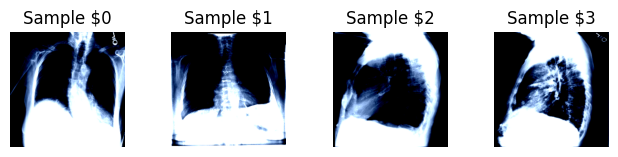

In [216]:
fig = plt.figure()

data_iter = iter(train_generator)
batch_imgs, batch_labels = next(data_iter)

for i in range(0,4):
    img, label = batch_imgs[i].numpy(), batch_labels[i].numpy()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample ${i}')
    ax.axis('off')

    plt.imshow(img.transpose(1, 2, 0))

## Definindo a função Loss

#### Cálculo das frequências de classe

In [219]:
def compute_class_freqs(labels):

    positive_frequencies = np.round(np.sum(labels,axis=0) / len(labels), 4)
    negative_frequencies = np.round([1-pf for pf in positive_frequencies], 4)

    return positive_frequencies, negative_frequencies

In [220]:
freq_pos, freq_neg = compute_class_freqs(df_train[train_generator.dataset.y_cols].values)

#### Definição dos pesos

In [221]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

#### Definição da função Loss ponderada

In [222]:
def weighted_loss(y_true, y_pred, w_p, w_n, epsilon=1e-7):
    y_pred = torch.clamp(y_pred, epsilon, 1.0 - epsilon)
    return -torch.mean(
        w_p * y_true * torch.log(y_pred)
        + w_n * (1 - y_true) * torch.log(1 - y_pred)
    )

## DenseNet

In [223]:
# Create the base pre-trained model
base_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
num_features = base_model.classifier.in_features

# Add layers
base_model.classifier = nn.Sequential(
    nn.Linear(num_features, len(labels)),
    nn.Sigmoid()
)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Treino

In [224]:
num_epochs = 1

# Define the loss function
criterion = nn.BCELoss(weight=torch.Tensor(pos_weights))

# Define the optimizer
optimizer = torch.optim.Adam(base_model.parameters())

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = base_model.to(device)
criterion = criterion.to(device)

# Training loop
for epoch in range(num_epochs):
    base_model.train()
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    for i, (x_batch, y_batch) in enumerate(train_generator):

        # Send data to the GPU
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Reset the gradients to zero
        optimizer.zero_grad()

        # Generate predictions
        outputs = base_model(x_batch).squeeze()

        # Calculate loss
        loss = criterion(outputs.float(), y_batch.float())

        # Compute gradients
        loss.backward()

        # Upgrade parameters using gradients
        optimizer.step()

        print(f'i {i} loss: {loss}')

Epoch 0/0
----------
i 0 loss: 0.6314263939857483
i 1 loss: 0.46000197529792786
i 2 loss: 0.36613336205482483
i 3 loss: 0.3167228400707245
i 4 loss: 0.23427042365074158
i 5 loss: 0.2797003984451294
i 6 loss: 0.22762329876422882
i 7 loss: 0.3190920054912567
i 8 loss: 0.08507762104272842
i 9 loss: 0.16048483550548553
i 10 loss: 0.16902337968349457
i 11 loss: 0.4712071716785431
i 12 loss: 0.11902637034654617
i 13 loss: 0.2733251750469208
i 14 loss: 0.05159926414489746
i 15 loss: 0.18915541470050812
i 16 loss: 0.3544396758079529
i 17 loss: 0.15638375282287598
i 18 loss: 0.06047377362847328
i 19 loss: 0.25053349137306213
i 20 loss: 0.0773514062166214
i 21 loss: 0.09405766427516937
i 22 loss: 0.23993106186389923
i 23 loss: 0.2648574411869049
i 24 loss: 0.11524533480405807
i 25 loss: 0.12346821278333664
i 26 loss: 0.22194433212280273
i 27 loss: 0.3016931116580963
i 28 loss: 0.31484466791152954
i 29 loss: 0.3298788070678711
i 30 loss: 0.34016361832618713
i 31 loss: 0.10811559855937958
i 32 los

## Teste

In [232]:
# Código baseado em trechos do artigo:
# Vision Transformers from Scratch (PyTorch): A step-by-step guide por Brian Pulfer
# disponível em https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

import warnings
warnings.filterwarnings('ignore')

# Test loop
with torch.no_grad():

    correct, total = 0, 0
    test_loss = 0.0

    for i, (x_batch, y_batch) in enumerate(valid_generator):

        # Send data to the GPU
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Generate predictions
        output = model(x_batch).squeeze()

        # Calculate loss
        loss = criterion(output.float(), y_batch.float())

        # Increment test loss
        test_loss += loss.detach().cpu().item() / len(valid_generator)

        # Calculate correct classification rate
        correct += torch.sum(torch.argmax(output, dim=0) == y_batch).detach().cpu().item()
        total += len(x_batch)

    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Test loss: 0.34
Test accuracy: 50.00%


## Vision Transformers

In [234]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.9 MB/s eta 0:00:00


In [249]:
from transformers import AutoImageProcessor, DeiTForImageClassification

# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
base_model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224")
N_EPOCHS = 5
LR = 0.005

num_features = base_model.classifier.in_features

# Add layers
base_model.classifier = nn.Sequential(
    nn.Linear(num_features, len(labels)),
    nn.Sigmoid()
)

Using device:  cpu 


Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['distillation_classifier.weight', 'cls_classifier.bias', 'cls_classifier.weight', 'distillation_classifier.bias']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream t

### Treino

In [255]:
num_epochs = 1

# Define the loss function
criterion = nn.BCELoss(weight=torch.Tensor(pos_weights))

# Define the optimizer
optimizer = torch.optim.Adam(base_model.parameters())

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = base_model.to(device)
criterion = criterion.to(device)

# Training loop
for epoch in range(num_epochs):
    base_model.train()
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    for i, (x_batch, y_batch) in enumerate(train_generator):

        # Send data to the GPU
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Reset the gradients to zero
        optimizer.zero_grad()

        # Generate predictions
        outputs = base_model(x_batch)

        # Calculate loss
        loss = criterion(outputs.logits.float(), y_batch.float())

        # Compute gradients
        loss.backward()

        # Upgrade parameters using gradients
        optimizer.step()

        print(f'i {i} loss: {loss}')

Epoch 0/0
----------
i 0 loss: 0.3157629072666168
i 1 loss: 0.22157125174999237
i 2 loss: 0.20821373164653778
i 3 loss: -0.10498517006635666
i 4 loss: 0.02185153402388096
i 5 loss: -0.01663334295153618
i 6 loss: 0.1580922156572342
i 7 loss: -0.36317214369773865
i 8 loss: 0.23534992337226868
i 9 loss: 0.022935407236218452
i 10 loss: 0.3729122281074524
i 11 loss: 0.14080402255058289
i 12 loss: -0.02042769081890583
i 13 loss: 0.2947467863559723
i 14 loss: 0.501846969127655
i 15 loss: 0.34008631110191345
i 16 loss: -0.13805635273456573
i 17 loss: 0.27134639024734497
i 18 loss: 0.017770128324627876
i 19 loss: 0.3927823007106781
i 20 loss: -0.030367868021130562
i 21 loss: -0.002433182904496789
i 22 loss: 0.32373788952827454
i 23 loss: 0.2870838940143585
i 24 loss: 0.209853857755661
i 25 loss: 0.28890296816825867
i 26 loss: 0.21371105313301086
i 27 loss: 0.12243904173374176
i 28 loss: 0.5767515897750854
i 29 loss: 0.06509564816951752
i 30 loss: 0.30849629640579224
i 31 loss: 0.349399745464324

### Teste

In [259]:
# Código baseado em trechos do artigo:
# Vision Transformers from Scratch (PyTorch): A step-by-step guide por Brian Pulfer
# disponível em https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

# Test loop
with torch.no_grad():

    correct, total = 0, 0
    test_loss = 0.0

    for i, (x_batch, y_batch) in enumerate(valid_generator):

        # Send data to the GPU
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Generate predictions
        output = model(x_batch)

        # Calculate loss
        loss = criterion(output.logits.float(), y_batch.float())

        # Increment test loss
        test_loss += loss.detach().cpu().item() / len(valid_generator)

        # Calculate correct classification rate
        correct += torch.sum(torch.argmax(output.logits, dim=0) == y_batch).detach().cpu().item()
        total += len(x_batch)

    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Test loss: 0.55
Test accuracy: 225.00%
